In [1]:
import random
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from deap import base, tools, creator, algorithms

In [2]:
data = pd.read_csv('employee_shift.csv')
data.sample(20)

,Employee_Name,Day_of_the_Month,Day_of_the_Week,Gender,Religion,Shift_ID
170,Retno,16,Rabu,Perempuan,Islam,4
368,Putri,28,Senin,Perempuan,Islam,3
15,Dimas,16,Rabu,Laki-laki,Islam,6
40,Dinda,10,Kamis,Perempuan,Islam,6
172,Retno,18,Jum'at,Perempuan,Islam,7
386,Sri Wahyuni,15,Selasa,Perempuan,Islam,6
63,Riza,2,Rabu,Laki-Laki,Islam,5
322,Rini,13,Minggu,Perempuan,Islam,6
102,Estu,10,Kamis,Perempuan,Islam,3
254,Dzaki,7,Senin,Laki-laki,Islam,1


In [3]:
# Define shift schedule (shift ID)
SHIFTS = {
    1: ("10:00 AM", "18:00 PM"),
    2: ("14:00 PM", "22:00 PM"),
    3: ("12:00 PM", "20:00 PM"),
    4: ("10:00 AM", "20:00 PM"),
    5: ("10:00 AM", "19:00 PM"),
    6: ("10:00 AM", "22:00 PM"), # Full Shift
    7: ("OFF", "OFF DAY") # Off Day
}

# Setup DEAP genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [4]:
def init_individual():
    # Create a schedule for each employee, instead of a single shift
    num_employees = len(data)
    # Create a list of schedules for each employee. Each schedule is a list of 7 shifts
    return [[random.choice(list(SHIFTS.keys())) for _ in range(7)]
            for _ in range(num_employees)]

def custom_mutation(individual, indpb):
    """Custom mutation to handle integer shift IDs."""
    # Iterate through each employee's schedule
    for employee_schedule in individual:
        # Iterate through each day in the schedule
        for i in range(len(employee_schedule)):
            if random.random() < indpb:
                # Instead of flipping the bit, select a new random shift ID
                employee_schedule[i] = random.choice(list(SHIFTS.keys()))
    return individual,  # Return the modified individual as a tuple

In [5]:
# Aturan 1: Tidak boleh mengambil cuti pada akhir pekan
def rule_weekend_no_off(schedule):
    weekday_off_count = 0
    for i in range(0, 5):  # Check for Monday-Friday
        if schedule[i] == 7:
            weekday_off_count += 1
    if weekday_off_count > 1:
        return False
    return True

# Aturan 2: Shift sebelum dan setelah libur
def rule_shift_before_after_off(schedule):
    for i in range(1, len(schedule)-1):
        if schedule[i] == 7:  # Check for "OFF" day
            if schedule[i-1] not in [1, 4] or schedule[i+1] != 2:  # Before OFF must be shift 1 or 4, after must be 2
                return False
    return True

# Aturan 3: Laki-laki Muslim tidak boleh mengambil shift 1, 3, 4 pada hari Jumat
def rule_friday_shift(schedule, employee):
    friday_shift = schedule[5]  # Index 5 is Friday
    # Ensure Gender and Religion exist in the dataframe, may need to modify the columns
    # based on their actual names in your file.
    gender_col = 'Gender'  # or 'Jenis Kelamin', 'gender', etc.
    religion_col = 'Religion'  # or 'Agama', 'religion', etc.
    if gender_col in employee and religion_col in employee:
        if employee[gender_col] == 'Male' and employee[religion_col] == 'Islam' and friday_shift in [1, 3, 4]:
            return False
    return True

# Rule 4: Karyawan ditempatkan di shift 4 pada akhir pekan (Jumat hingga Minggu)
def rule_weekend_shift(schedule):
    weekend_shifts = [schedule[5], schedule[6]]  # Jumat dan Sabtu (assuming index 5 and 6 are Friday and Saturday)
    if any(shift != 4 for shift in weekend_shifts):  # Should be shift 4
        return False
    return True

# Rule 5: Minimal dua orang untuk menutup toko di shift malam (shift 6)
def rule_min_two_for_closing(schedules):
    for day in range(len(schedules[0])):  # Loop over each day
        shift_count = sum(1 for schedule in schedules if schedule[day] == 6)
        if shift_count < 2:
            return False
    return True

# Rule 6: Hindari shift pagi setelah shift malam
def rule_no_morning_after_night(schedule):
    for i in range(1, len(schedule)):
        if schedule[i-1] == 6 and schedule[i] == 1:  # If night shift followed by morning shift
            return False
    return True

# Fungsi fitness
def evaluate(individual):
    total_penalty = 0
    for idx, employee_schedule in enumerate(individual):
        employee = data.iloc[idx]  # Get employee data from dataframe
        if not rule_weekend_no_off(employee_schedule):
            total_penalty += 10
        if not rule_friday_shift(employee_schedule, employee):
            total_penalty += 20
        if not rule_shift_before_after_off(employee_schedule):
            total_penalty += 15
        if not rule_weekend_shift(employee_schedule):
            total_penalty += 10
        if not rule_min_two_for_closing(individual):
            total_penalty += 20
        if not rule_no_morning_after_night(employee_schedule):
            total_penalty += 10
    return (total_penalty,)

In [6]:
toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
# Functions for crossover, mutation, selection
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", custom_mutation, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
# Genetic algorithm parameters
population_size = 150
generations = 200
crossover_prob = 0.7
mutation_prob = 0.3

# Generate initial population
pop = toolbox.population(n=population_size)

# Create stats object
mstats = tools.Statistics(lambda ind: ind.fitness.values)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Create Hall of Fame object
hof = tools.HallOfFame(1) # Keep only the best individual

# Run the genetic algorithm
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob,
                    mutpb=mutation_prob, ngen=generations,
                    verbose=True, stats=mstats, halloffame=hof)

# Get the best individual
best_individual = tools.selBest(pop, k=1)[0]
print("Best Schedule found:", best_individual)

# Map shift IDs to actual shifts
final_schedule = []

# Iterate through each employee's schedule
for employee_schedule in best_individual:
    employee_final_schedule = []
    # Iterate through each day's shift ID in the employee's schedule
    for shift_id in employee_schedule:
        employee_final_schedule.append(SHIFTS[shift_id])
    final_schedule.append(employee_final_schedule)

gen	nevals	avg    	std    	min 	max 
0  	150   	8164.43	189.114	7695	8710
1  	106   	7951.17	139.502	7635	8375
2  	113   	7796.87	130.421	7455	8245
3  	115   	7667.47	108.607	7440	7940
4  	113   	7544.43	92.9759	7250	7755
5  	122   	7443.97	98.6277	7190	7735
6  	114   	7357.93	102.731	6895	7635
7  	112   	7249.7 	110.09 	6885	7560
8  	120   	7142.47	111.584	6895	7465
9  	121   	7048.97	94.282 	6800	7310
10 	118   	6963.03	96.1837	6730	7270
11 	113   	6874.1 	87.6719	6665	7090
12 	101   	6799.07	86.6437	6570	7115
13 	116   	6748.4 	85.0418	6540	6970
14 	117   	6692.87	75.7899	6480	6995
15 	128   	6629.47	79.9899	6370	6865
16 	107   	6571.9 	97.3236	6375	6900
17 	118   	6500.6 	94.6166	6320	6810
18 	116   	6438.7 	80.9227	6265	6765
19 	113   	6398.03	70.5571	6220	6620
20 	119   	6365.1 	76.9079	6210	6600
21 	118   	6333.13	80.1718	6210	6605
22 	111   	6292.97	82.4623	6145	6550
23 	127   	6253.83	83.5333	6120	6545
24 	109   	6208.17	85.9717	6065	6475
25 	114   	6175.8 	92.0563	6010	6545
2

In [8]:
print(final_schedule)

[[('10:00 AM', '19:00 PM'), ('10:00 AM', '18:00 PM'), ('12:00 PM', '20:00 PM'), ('12:00 PM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('14:00 PM', '22:00 PM')], [('10:00 AM', '19:00 PM'), ('10:00 AM', '18:00 PM'), ('10:00 AM', '18:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '18:00 PM'), ('12:00 PM', '20:00 PM')], [('10:00 AM', '19:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '18:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '22:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '19:00 PM')], [('10:00 AM', '19:00 PM'), ('10:00 AM', '19:00 PM'), ('12:00 PM', '20:00 PM'), ('12:00 PM', '20:00 PM'), ('10:00 AM', '19:00 PM'), ('12:00 PM', '20:00 PM'), ('OFF', 'OFF DAY')], [('10:00 AM', '20:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '19:00 PM'), ('12:00 PM', '20:00 PM'), ('10:00 AM', '18:00 PM'), ('OFF', 'OFF DAY')], [('10:00 AM', '18:00 PM'), ('OFF', 'OFF DAY'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '19:0

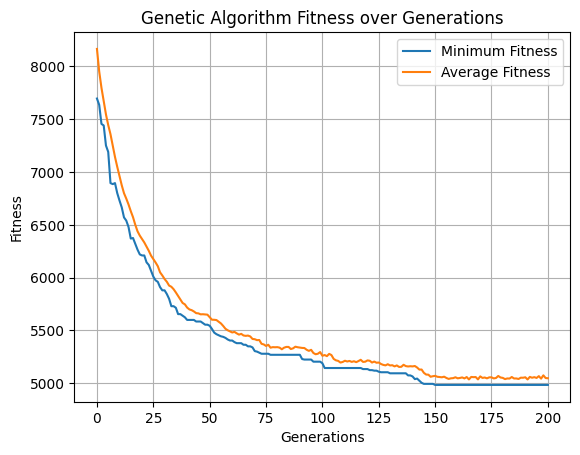

In [9]:
# Extract the fitness values from the logbook
min_fitness_values = [x['min'] for x in logbook]
avg_fitness_values = [x['avg'] for x in logbook]

# Plot the fitness values
plt.plot(min_fitness_values, label='Minimum Fitness')
plt.plot(avg_fitness_values, label='Average Fitness')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Genetic Algorithm Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print("Best individual is: %s, %s" % (hof[0], hof[0].fitness))

Best individual is: [[5, 1, 3, 3, 4, 4, 2], [5, 1, 1, 6, 6, 1, 3], [5, 4, 1, 4, 6, 2, 5], [5, 5, 3, 3, 5, 3, 7], [4, 2, 5, 5, 3, 1, 7], [1, 7, 5, 5, 2, 6, 4], [6, 6, 6, 3, 6, 2, 4], [7, 1, 2, 2, 6, 6, 7], [2, 5, 1, 2, 2, 3, 4], [7, 3, 1, 3, 5, 3, 3], [7, 5, 3, 5, 5, 2, 6], [2, 4, 4, 3, 2, 5, 2], [7, 2, 2, 1, 3, 5, 1], [5, 7, 2, 3, 4, 3, 3], [4, 2, 6, 3, 1, 1, 4], [6, 2, 3, 2, 3, 2, 1], [5, 3, 2, 1, 6, 4, 7], [5, 3, 2, 4, 3, 4, 4], [3, 7, 1, 2, 6, 2, 7], [1, 1, 3, 2, 5, 1, 1], [5, 2, 3, 2, 6, 4, 4], [4, 4, 5, 4, 3, 1, 1], [5, 2, 2, 6, 1, 5, 2], [4, 1, 7, 5, 1, 7, 5], [4, 2, 6, 3, 2, 4, 6], [3, 2, 5, 6, 7, 4, 4], [2, 6, 2, 3, 1, 5, 4], [3, 1, 5, 4, 7, 2, 4], [2, 2, 6, 5, 1, 5, 1], [3, 3, 4, 5, 5, 3, 2], [5, 4, 3, 4, 2, 4, 2], [7, 1, 5, 4, 1, 6, 6], [2, 1, 2, 3, 2, 3, 7], [3, 2, 7, 3, 4, 2, 4], [5, 4, 5, 2, 6, 6, 2], [6, 3, 2, 3, 3, 6, 7], [6, 3, 4, 4, 5, 3, 2], [5, 7, 6, 4, 4, 6, 6], [4, 4, 1, 7, 2, 7, 3], [5, 2, 1, 1, 6, 5, 6], [2, 5, 5, 6, 2, 2, 6], [3, 2, 5, 5, 1, 6, 5], [5, 1, 3, 4, 

In [11]:
# Create a list to store the data for the new dataframe
employee_data = []

# Iterate through each employee's schedule in the best individual
for employee_index, employee_schedule in enumerate(best_individual):
  employee_name = data.iloc[employee_index][0]  # Assuming the name is in the first column
  # Assuming 'SHIFTS' is a dictionary mapping shift IDs to their values
  schedule_details = []
  for day, shift_id in enumerate(employee_schedule):
    start_time, end_time = SHIFTS[shift_id]  # Get shift start and end times
    day_name = calendar.day_name[(datetime.now().weekday() + day) % 7]  # Calculate day name
    schedule_details.append({
        'Day': day_name,
        'Shift': (start_time, end_time)  # Store shift as a tuple or another suitable format
    })
  employee_data.append({
      'Employee': employee_name,
      'Schedule': schedule_details
  })

# Convert the list to a dataframe
result_df = pd.DataFrame(employee_data)
result_df

# Save the dataframe to a CSV file
result_df.to_csv('schedule_result_5.csv', index=False)

C:\Users\hendr\AppData\Local\Temp\ipykernel_15392\4052218462.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  employee_name = data.iloc[employee_index][0]  # Assuming the name is in the first column
